# 二分类

In [1]:
import numpy as np
# %matplotlib widget
from matplotlib import pyplot as plt

## 单量指标
| 真实结果 | 预测结果 | 预测结果 |
| ----- | --------- | ----------- |
|    | 真 | 假 |
| 真 | TP | FN |
| 假 | FP | TN |

$$
\begin{aligned}
Accuracy &= \frac {TP+TN}{TP+FP+FN+TN}\\ \\
Precision &= \frac {TP}{TP+FP}\\ \\
Recall &= \frac {TP}{TP+FN}\\ \\
F_1 &= \frac {2\times Precision \times Recall}{Precision + Recall}
\end{aligned}
$$

In [2]:
def singleMetics(P, T):
    TP = ((P==1) & (T==1)).sum()
    FP = ((P==0) & (T==1)).sum()
    FN = ((P==1) & (T==0)).sum()
    TN = ((P==0) & (T==0)).sum()
    Accuracy = (TP+TN)/len(P)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1 = (2*Precision*Recall)/(Precision+Recall)
    return { 'TP':TP, 'FP':FP, 'FN':FN, 'TN':TN, 'Accuracy':Accuracy,
             'Precision':Precision, 'Recall':Recall, 'F1':F1}

## P-R曲线
选择不同的置信度，以 Precision 为 Y 轴，Recall 为 X 轴的曲线

In [3]:
def PRcurve(y_prob, y_true, plot=False):
    # 排序
    sorted_indices = np.argsort(y_prob)[::-1]
    y_prob = y_prob[sorted_indices]
    y_true = y_true[sorted_indices]
    
    precisions = []
    recalls = []
    thresholds = []
    
    # 如果 y_prob 没有 1，则手动添加一个 (0,1) 坐标
    # 防止 Precision 分母/分子 皆为 0
    if y_prob[0] != 1:
        precisions.append(1)
        recalls.append(0)
        thresholds.append(1)
    
    # 初始化：全部预测为 False
    TP = 0
    FP = 0
    FN = y_true.sum().item()
    for prob, true in zip(y_prob, y_true):
        if true == 1:
            TP += 1
            FN -= 1
        else:
            FP += 1
        P = TP/(TP+FP)
        R = TP/(TP+FN)
        precisions.append(P)
        recalls.append(R)
        thresholds.append(prob)
        # 当 Recall 为 1 时，就可以退出了
        if R == 1:
            break
    
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    thresholds = np.array(thresholds)
    
    if plot:
        fig = plt.figure()
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.plot(recalls, precisions)
        plt.fill_between(recalls, precisions, color='lightblue')
    
    return precisions, recalls, thresholds

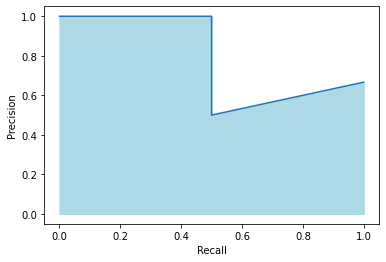

In [4]:
y_true = np.array([0, 0, 1, 1])
y_prob = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = PRcurve(y_prob, y_true, plot=True)

In [5]:
# 与 sklearn 中的 metrics 比较
import numpy as np
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

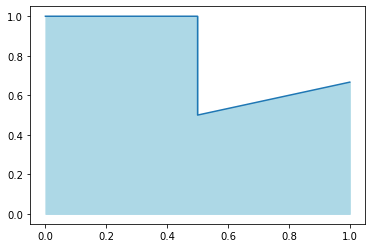

In [6]:
# 效果一致
fig = plt.figure()
plt.plot(recall, precision)
plt.fill_between(recall, precision, color='lightblue');

### AP
PR 曲线 之下的面积

In [7]:
def AP(y_prob, y_true):
    P, R, _ = PRcurve(y_prob, y_true)
    maxPs = list(set(P))
    maxPs.sort(reverse=True)
    S = 0
    prevr = 0
    for maxP in maxPs:
        r = R[np.where(P == maxP)[0].max()]
        S += maxP*(r-prevr)
        prevr = r
        if r == 1:
            break
    return S

In [8]:
AP(y_prob, y_true)

0.8333333333333333

In [9]:
# 效果完全一致
from sklearn.metrics import average_precision_score
average_precision_score(y_true, y_prob)

0.8333333333333333

### 平衡点 BEP
PR 曲线 和 x=y 的交点

In [10]:
def BEP(y_prob, y_true):
    P, R, _ = PRcurve(y_prob, y_true)
    return P[P<=R].max()

In [11]:
BEP(y_prob, y_true)

0.6666666666666666

## ROC 曲线
Receiver Operating Characteristic Curve
选择不同的置信度，以FPR值为横坐标和TPR值为纵坐标

$$
FPR = \frac {FP}{FP+TN}
$$

$$
TPR = \frac {TP}{TP+FN}
$$

In [12]:
def ROCcurve(y_prob, y_true, plot=False):
    # 排序
    sorted_indices = np.argsort(y_prob)[::-1]
    y_prob = y_prob[sorted_indices]
    y_true = y_true[sorted_indices]
    
    FPR = []
    TPR = []
    thresholds = []
    
    # 初始化：全部预测为 False
    TP = 0
    FP = 0
    FN = y_true.sum().item()
    TN = len(y_true) - FN
    fpr = FP/(FP+TN)
    TPR = TP/(TP+FN)
    FPR.append(fpr)
    TPR.append(TPR)
    thresholds.append(1.)
    
    for prob, true in zip(y_prob, y_true):
        if true == 1:
            TP += 1
            FN -= 1
        else:
            FP += 1
            TN -= 1
        fpr = FP/(FP+TN)
        TPR = TP/(TP+FN)
        FPR.append(fpr)
        TPR.append(TPR)
        thresholds.append(prob)
    
    FPR = np.array(FPR)
    TPR = np.array(TPR)
    thresholds = np.array(thresholds)
    
    if plot:
        fig = plt.figure()
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.plot(FPR, TPR)
        plt.fill_between(FPR, TPR, color='lightblue')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    return TPR, FPR, thresholds

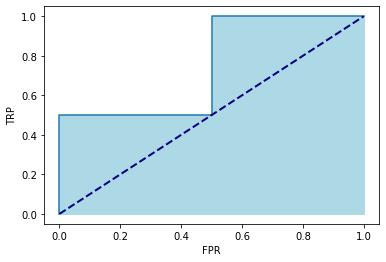

In [13]:
ROCcurve(y_prob, y_true, plot=True);

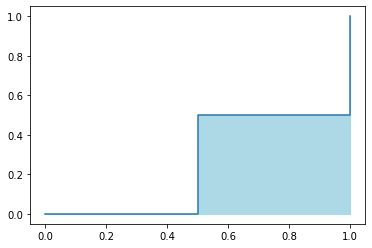

In [14]:
from sklearn.metrics import roc_curve
tpr, fpr, _ = roc_curve(y_true, y_prob)
fig = plt.figure()
plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, color='lightblue');
# 效果完全相反

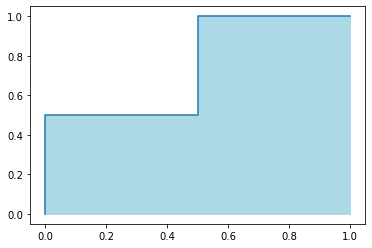

In [15]:
# 颠倒一下标签 0，1 才一致
# 感觉我没问题啊，sklearn 写反了吧
tpr, fpr, _ = roc_curve(y_true, y_prob, pos_label=0)
fig = plt.figure()
plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, color='lightblue');

### AUC
ROC 曲线下的面积

In [16]:
def AUC(y_prob, y_true):
    TPR, FPR, _ = ROCcurve(y_prob, y_true, plot=False)
    prevfpr = 0
    S = 0
    for TPR, fpr in zip(TPR, FPR):
        S += (fpr-prevfpr)*TPR
        prevfpr = fpr
    return S

In [17]:
AUC(y_prob, y_true)

0.75

In [18]:
from sklearn.metrics import auc
auc(fpr, tpr)
# 结果一致

0.75